In [1]:
from azureml.core import Workspace, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime
import pickle
from random import seed
from random import random

# Päiväkohtainen ennuste 22.3.-11.4.2019

In [2]:
start = pd.Timestamp('2019-01-01T00') # Siirtymätodennäköisyyksien laskemisen aloituspäivä
# start_L1 = pd.Timestamp('2019-02-01T00')
start_day = pd.Timestamp('2019-03-01T00') # Ennusteajankohta
train_test_day = pd.Timestamp('2019-03-01')
end = pd.Timestamp('2019-05-01T00')

## Lasten päivystys

In [3]:
subscription_id = '4371739e-d07f-42d5-a3a6-efa120c1e246'
resource_group = 'husfd-tu-dip-potilasvirrat'
workspace_name = 'husfd-tu-dip-potilasvirrat-ml'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='uranus27_1')
features = ['kaynti_numero', 'potilasnumero', 'henkilotunnus', 'alkuhetki', 'loppuhetki',
       'vo_toimipiste_nimi', 'kayntityyppi_selite', 'varaustyyppi_selite',
       'mista_tuli_selite', 'res_koodi', 'res_selite', 'jh_selite', 
       'jatkoh_laitos_nimi', 'jatkoh_toimipiste_nimi']
df = dataset.to_pandas_dataframe()[features]
df.dropna(subset=['alkuhetki', 'loppuhetki'], inplace=True)
df.drop_duplicates(subset='kaynti_numero', inplace=True)
df = df[df['varaustyyppi_selite'] != 'PÄIV PKL soitto']
df = df[(df['kayntityyppi_selite'] != 'Hoitokäynti') & (df['kayntityyppi_selite'] != 'Ohjattu muualle') & (df['kayntityyppi_selite'] !='HYKSin Oy:n potilas') & (df['kayntityyppi_selite'] != 'Sarjahoitokäynti') & (df['kayntityyppi_selite'] != 'Ensikäynti')]
df = df[(df.alkuhetki >= start) & (df.alkuhetki < end)]
df_train = df[df.alkuhetki < train_test_day]
df_test = df[df.alkuhetki >= train_test_day]
pd.set_option('display.max_columns', None)
df_train = df_train.sort_values(by='alkuhetki')
#df_train.head()

Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'


## L1-osasto

In [4]:
subscription_id = '4371739e-d07f-42d5-a3a6-efa120c1e246'
resource_group = 'husfd-tu-dip-potilasvirrat'
workspace_name = 'husfd-tu-dip-potilasvirrat-ml'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset_ward = Dataset.get_by_name(workspace, name='uranus27_2')
features_ward = ['henkilotunnus', 'alkuhetki', 'loppuhetki', 'vo_toimipiste_nimi', 'pot_eala_selite', 'paadg_oire_selite', 'mista_lah_tuli_koodi',
       'mista_lah_tuli_nimi', 'mista_tuli_koodi', 'mista_tuli_selite', 'jatkoh_laitos_nimi',
       'jatkoh_toimipiste_nimi', 'jh_koodi', 'jh_selite', 'osastohoito_numero', 'shjakso_numero']
ward = dataset_ward.to_pandas_dataframe()[features_ward]
ward.replace("", float("NaN"), inplace=True)
ward.dropna(subset=['alkuhetki', 'loppuhetki'], inplace=True)
ward.drop_duplicates(subset='osastohoito_numero', inplace=True)
ward = ward[(ward.alkuhetki >= start) & (ward.alkuhetki < end)]
ward_train = ward[ward.alkuhetki < train_test_day]
ward_test = ward[ward.alkuhetki >= train_test_day]
pd.set_option('display.max_columns', None)
ward_train = ward_train.sort_values(by='alkuhetki')
#ward_train.head()

Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'


In [5]:
df_train.kayntityyppi_selite.unique()

array(['Päivystys', 'Tk-päivystys', 'Tk-hoitokäynti', 'Uusintakäynti',
       'Lisäkäynti', 'Poistunut hoidott'], dtype=object)

In [6]:
df_train['alkuhetki'] = pd.to_datetime(df_train['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
df_train['loppuhetki'] = pd.to_datetime(df_train['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
df_train = df_train[df_train['alkuhetki'] <= df_train['loppuhetki']]
df_train['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = df_train['alkuhetki'], right = df_train['loppuhetki'], closed='neither')
df_train['palveluaika'] = ((df_train['loppuhetki'] - df_train['alkuhetki']).astype('timedelta64[s]') / 3600)
df_train['alku'] = df_train.alkuhetki
df_train['loppu'] = df_train.loppuhetki

In [7]:
df['alkuhetki'] = pd.to_datetime(df['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
df['loppuhetki'] = pd.to_datetime(df['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
df = df[df['alkuhetki'] <= df['loppuhetki']]
df['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = df['alkuhetki'], right = df['loppuhetki'], closed='neither')
df['palveluaika'] = ((df['loppuhetki'] - df['alkuhetki']).astype('timedelta64[s]') / 3600)

In [8]:
ward_train['alkuhetki'] = pd.to_datetime(ward_train['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_train['loppuhetki'] = pd.to_datetime(ward_train['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_train = ward_train[ward_train['alkuhetki'] <= ward_train['loppuhetki']]
ward_train['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward_train['alkuhetki'], right = ward_train['loppuhetki'], closed='neither')
ward_train['palveluaika'] = np.round(((ward_train['loppuhetki'] - ward_train['alkuhetki']).astype('timedelta64[s]') / 3600 / 24))
ward_train['p_siirtymä'] = 1 / ward_train['palveluaika']
ward_train['alku'] = ward_train.alkuhetki
ward_train['loppu'] = ward_train.loppuhetki
ward_train.reset_index(drop=True, inplace=True)

In [9]:
ward_test['alkuhetki'] = pd.to_datetime(ward_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test['loppuhetki'] = pd.to_datetime(ward_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test = ward_test[ward_test['alkuhetki'] <= ward_test['loppuhetki']]
ward_test['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward_test['alkuhetki'], right = ward_test['loppuhetki'], closed='neither')
ward_test['palveluaika'] = ((ward_test['loppuhetki'] - ward_test['alkuhetki']).astype('timedelta64[s]') / 3600 / 24)
ward_test['alku'] = ward_test.alkuhetki
ward_test['loppu'] = ward_test.loppuhetki
ward_test.reset_index(drop=True, inplace=True)

/tmp/ipykernel_31648/3304619986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward_test['alkuhetki'] = pd.to_datetime(ward_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_31648/3304619986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward_test['loppuhetki'] = pd.to_datetime(ward_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")


In [10]:
ward['alkuhetki'] = pd.to_datetime(ward['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward['loppuhetki'] = pd.to_datetime(ward['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward = ward[ward['alkuhetki'] <= ward['loppuhetki']]
ward['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward['alkuhetki'], right = ward['loppuhetki'], closed='neither')
ward['palveluaika'] = ((ward['loppuhetki'] - ward['alkuhetki']).astype('timedelta64[s]') / 3600 / 24)
ward['alku'] = ward.alkuhetki
ward['loppu'] = ward.loppuhetki
ward.reset_index(drop=True, inplace=True)

### Siirtymätodennäköisyydet lasten päivystys

In [11]:
aika = start
span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(61)]})
timestamp_day = [aika + timedelta(days=x) for x in range(60)]
df_train_day = pd.DataFrame(data={'time':timestamp_day})
df_train_day['weekday'] = df_train_day['time'].dt.weekday
df_train_day['month'] = df_train_day['time'].dt.month
df_train_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
df_train_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).overlaps(b) for b in df_train['aikaväli']]).sum()

for t in range(len(df_train_day['timespan'])):
    sum = 0
    for a, b in zip(df_train['aikaväli'], df_train['loppuhetki']):
        if ((df_train_day.loc[t, 'timespan'].overlaps(a)) == True) & ((b in df_train_day.loc[t, 'timespan']) == False):
            sum += 1
    df_train_day.loc[t, 'päiv'] = sum

df_train_day['JOL1'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).contains(b) for b in df_train[df_train.jatkoh_laitos_nimi == 'JOL1'].loppuhetki]).sum()
df_train_day['koti'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).contains(b) for b in df_train[df_train.jh_selite == 'Koti'].loppuhetki]).sum()
df_train_day['muu'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).contains(b) for b in df_train[(df_train.jh_selite != 'Koti') & (df_train.jatkoh_laitos_nimi != 'JOL1')].loppuhetki]).sum()
df_train_day.set_index('time', inplace=True)
df_train_day.head()

,weekday,month,timespan,patient_count,päiv,JOL1,koti,muu
time,,,,,,,,
2019-01-01,1,1,"[2019-01-01, 2019-01-02)",71,1.0,3,66,1
2019-01-02,2,1,"[2019-01-02, 2019-01-03)",67,2.0,4,61,0
2019-01-03,3,1,"[2019-01-03, 2019-01-04)",71,10.0,5,56,0
2019-01-04,4,1,"[2019-01-04, 2019-01-05)",64,4.0,6,54,2
2019-01-05,5,1,"[2019-01-05, 2019-01-06)",81,7.0,2,71,1


In [12]:
df_train_day['päiv_prob'] = df_train_day.päiv / df_train_day.patient_count
df_train_day['JOL1_prob'] = df_train_day.JOL1 / df_train_day.patient_count
df_train_day['koti_prob'] = df_train_day.koti / df_train_day.patient_count
df_train_day['muu_prob'] = df_train_day.muu / df_train_day.patient_count
df_train_day_grouped = df_train_day.groupby(by='weekday')
train_mean = df_train_day_grouped.mean()
train_mean

/tmp/ipykernel_31648/2540102831.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_mean = df_train_day_grouped.mean()


,month,patient_count,päiv,JOL1,koti,muu,päiv_prob,JOL1_prob,koti_prob,muu_prob
weekday,,,,,,,,,,
0,1.500000,76.000000,4.125000,6.375000,65.250000,0.500000,0.057499,0.085929,0.853592,0.006542
1,1.444444,71.000000,7.777778,5.444444,57.444444,0.333333,0.114727,0.077109,0.803368,0.004796
2,1.444444,76.555556,5.333333,6.444444,64.444444,0.333333,0.066989,0.083206,0.846077,0.003728
3,1.444444,69.555556,6.333333,5.666667,57.333333,0.333333,0.089942,0.080271,0.825493,0.005632
4,1.666667,65.111111,5.222222,4.333333,54.888889,1.000000,0.069505,0.061658,0.859110,0.014420
5,1.500000,99.500000,8.875000,4.875000,85.000000,0.750000,0.087395,0.048156,0.856741,0.007709
6,1.500000,110.375000,7.000000,6.750000,96.375000,0.250000,0.063456,0.061132,0.873386,0.002026


In [13]:
df_test['alkuhetki'] = pd.to_datetime(df_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
df_test['loppuhetki'] = pd.to_datetime(df_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
df_test = df_test[df_test['alkuhetki'] <= df_test['loppuhetki']]
df_test['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = df_test['alkuhetki'], right = df_test['loppuhetki'], closed='neither')
df_test['palveluaika'] = ((df_test['loppuhetki'] - df_test['alkuhetki']).astype('timedelta64[s]') / 3600)
df_test['alku'] = df_test.alkuhetki
df_test['loppu'] = df_test.loppuhetki


In [14]:
aika = train_test_day
span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(220)]})
timestamp_day = [aika + timedelta(days=x) for x in range(219)]
df_test_day = pd.DataFrame(data={'time':timestamp_day})
df_test_day['weekday'] = df_test_day['time'].dt.weekday
df_test_day['month'] = df_test_day['time'].dt.month
df_test_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
df_test_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(df_test_day['timespan']).overlaps(b) for b in df_test['aikaväli']]).sum()
df_test_day.set_index('time', inplace=True)
df_test_day.head()

,weekday,month,timespan,patient_count
time,,,,
2019-03-01,4,3,"[2019-03-01, 2019-03-02)",50
2019-03-02,5,3,"[2019-03-02, 2019-03-03)",108
2019-03-03,6,3,"[2019-03-03, 2019-03-04)",131
2019-03-04,0,3,"[2019-03-04, 2019-03-05)",95
2019-03-05,1,3,"[2019-03-05, 2019-03-06)",74


In [15]:
print(df_train.jatkoh_laitos_nimi.unique())
print('JOL1 osastolle siirtyneet:', len(df_train[df_train.jatkoh_laitos_nimi == 'JOL1']) / len(df_train) * 100)
print('Ylipäätään jollekin osastolle siirtyneet:', len(df_train[df_train.jatkoh_laitos_nimi != '']) / len(df_train) * 100)
print('Sairaalaan jääneet:', len(df_train[df_train.jh_selite == 'Sairaala']) / len(df_train) * 100)

['' 'JOL1' 'LTÄHTI' 'ESPOON TK' 'NPSN1' 'HYKS-SHA' 'JOL2' 'LVUORI'
 'LAVARUUS' 'LTEHO']
JOL1 osastolle siirtyneet: 7.661199730397664
Ylipäätään jollekin osastolle siirtyneet: 8.24533812626376
Sairaalaan jääneet: 8.020669512469109


### Siirtymätodennäköisyydet JOL1

In [16]:
aika = start
span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(61)]})
timestamp_day = [aika + timedelta(days=x) for x in range(60)]
ward_train_day = pd.DataFrame(data={'time':timestamp_day})
ward_train_day['weekday'] = ward_train_day['time'].dt.weekday
ward_train_day['month'] = ward_train_day['time'].dt.month
ward_train_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
ward_train_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(ward_train_day['timespan']).overlaps(b) for b in ward_train['aikaväli']]).sum()

for t in range(len(ward_train_day['timespan'])):
    sum = 0
    for a, b in zip(ward_train['aikaväli'], ward_train['loppuhetki']):
        if ((ward_train_day.loc[t, 'timespan'].overlaps(a)) == True) & ((b in ward_train_day.loc[t, 'timespan']) == False):
            sum += 1
    ward_train_day.loc[t, 'JOL1'] = sum

ward_train_day['koti'] = pd.DataFrame([pd.arrays.IntervalArray(ward_train_day['timespan']).contains(b) for b in ward_train[ward_train.jh_selite == 'Koti'].loppuhetki]).sum()
ward_train_day['muu'] = pd.DataFrame([pd.arrays.IntervalArray(ward_train_day['timespan']).contains(b) for b in ward_train[ward_train.jh_selite == 'Sairaala'].loppuhetki]).sum()
ward_train_day.set_index('time', inplace=True)
ward_train_var = ward_train_day
#ward_train_day = ward_train_day[ward_train_day.index >= start_L1]

In [17]:
ward_train_day['JOL1_prob'] = ward_train_day.JOL1 / ward_train_day.patient_count
ward_train_day['koti_prob'] = ward_train_day.koti / ward_train_day.patient_count
ward_train_day['muu_prob'] = ward_train_day.muu / ward_train_day.patient_count
ward_train_day_grouped = ward_train_day.groupby(by='weekday')
ward_mean = ward_train_day_grouped.mean()
ward_mean

/tmp/ipykernel_31648/4270373818.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_mean = ward_train_day_grouped.mean()


,month,patient_count,JOL1,koti,muu,JOL1_prob,koti_prob,muu_prob
weekday,,,,,,,,
0,1.500000,23.250000,16.750000,6.125000,0.375000,0.717917,0.266841,0.015242
1,1.444444,21.111111,14.222222,6.333333,0.555556,0.685216,0.293721,0.021062
2,1.444444,21.888889,15.111111,6.555556,0.222222,0.701650,0.288615,0.009735
3,1.444444,22.222222,15.222222,6.666667,0.333333,0.685598,0.302021,0.012381
4,1.666667,20.777778,13.222222,6.888889,0.666667,0.639328,0.329102,0.031570
5,1.500000,18.750000,13.625000,4.625000,0.500000,0.717488,0.254501,0.028011
6,1.500000,21.125000,15.500000,5.125000,0.500000,0.752799,0.227403,0.019798


In [18]:
ward_test['alkuhetki'] = pd.to_datetime(ward_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test['loppuhetki'] = pd.to_datetime(ward_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test = ward_test[ward_test['alkuhetki'] <= ward_test['loppuhetki']]
ward_test['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward_test['alkuhetki'], right = ward_test['loppuhetki'], closed='neither')
ward_test['palveluaika'] = ((ward_test['loppuhetki'] - ward_test['alkuhetki']).astype('timedelta64[s]') / 3600)

In [19]:
aika = train_test_day
span_day_test = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(121)]})
timestamp_day_test = [aika + timedelta(days=x) for x in range(120)]
ward_test_day = pd.DataFrame(data={'time':timestamp_day_test})
ward_test_day['weekday'] = ward_test_day['time'].dt.weekday
ward_test_day['month'] = ward_test_day['time'].dt.month
ward_test_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day_test['time'][0:-1], right = span_day_test['time'][1:], closed='left')
ward_test_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(ward_test_day['timespan']).overlaps(b) for b in ward_test['aikaväli']]).sum()
ward_test_day.set_index('time', inplace=True)
ward_test_day.head()

,weekday,month,timespan,patient_count
time,,,,
2019-03-01,4,3,"[2019-03-01, 2019-03-02)",4
2019-03-02,5,3,"[2019-03-02, 2019-03-03)",4
2019-03-03,6,3,"[2019-03-03, 2019-03-04)",7
2019-03-04,0,3,"[2019-03-04, 2019-03-05)",16
2019-03-05,1,3,"[2019-03-05, 2019-03-06)",22


In [20]:
# Siirtymätodennäköisyyksine normalisointi 1
def smoothen_transition_probs(df_mean, columns):
    for names in columns:
        for row in range(len(df_mean)):
            probs_sum = np.sum([df_mean.at[row, n] for n in names])
            for n in names:
                df_mean.loc[df_mean.index == row, n] = df_mean.loc[df_mean.index == row, n] / probs_sum + 0.000000001
    return df_mean
    
train_mean = train_mean.reset_index()
columns = [['päiv_prob', 'JOL1_prob', 'muu_prob', 'koti_prob']]
train_mean = smoothen_transition_probs(train_mean, columns)

ward_mean = ward_mean.reset_index()
columns_ward = [['JOL1_prob', 'muu_prob', 'koti_prob']]
ward_mean = smoothen_transition_probs(ward_mean, columns_ward)

## Siirtymämatriisit

In [21]:
#           päivystys  JOL1  muu  koti
# päivystys
# JOL1
# muu
# koti

T_mon = [[train_mean.at[0, 'päiv_prob'], train_mean.at[0, 'JOL1_prob'], train_mean.at[0, 'muu_prob'], train_mean.at[0, 'koti_prob']],
         [0, ward_mean.at[0, 'JOL1_prob'], ward_mean.at[0, 'muu_prob'], ward_mean.at[0, 'koti_prob']],       
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_tue = [[train_mean.at[1, 'päiv_prob'], train_mean.at[1, 'JOL1_prob'], train_mean.at[1, 'muu_prob'], train_mean.at[1, 'koti_prob']],
         [0, ward_mean.at[1, 'JOL1_prob'], ward_mean.at[1, 'muu_prob'], ward_mean.at[1, 'koti_prob']],
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_wed = [[train_mean.at[2, 'päiv_prob'], train_mean.at[2, 'JOL1_prob'], train_mean.at[2, 'muu_prob'], train_mean.at[2, 'koti_prob']],
         [0, ward_mean.at[2, 'JOL1_prob'], ward_mean.at[2, 'muu_prob'], ward_mean.at[2, 'koti_prob']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_thu = [[train_mean.at[3, 'päiv_prob'], train_mean.at[3, 'JOL1_prob'], train_mean.at[3, 'muu_prob'], train_mean.at[3, 'koti_prob']],
         [0, ward_mean.at[3, 'JOL1_prob'], ward_mean.at[3, 'muu_prob'], ward_mean.at[3, 'koti_prob']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_fri = [[train_mean.at[4, 'päiv_prob'], train_mean.at[4, 'JOL1_prob'], train_mean.at[4, 'muu_prob'], train_mean.at[4, 'koti_prob']],
         [0, ward_mean.at[4, 'JOL1_prob'], ward_mean.at[4, 'muu_prob'], ward_mean.at[4, 'koti_prob']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]
         
T_sat = [[train_mean.at[5, 'päiv_prob'], train_mean.at[5, 'JOL1_prob'], train_mean.at[5, 'muu_prob'], train_mean.at[5, 'koti_prob']],
         [0, ward_mean.at[5, 'JOL1_prob'], ward_mean.at[5, 'muu_prob'], ward_mean.at[5, 'koti_prob']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_sun = [[train_mean.at[6, 'päiv_prob'], train_mean.at[6, 'JOL1_prob'], train_mean.at[6, 'muu_prob'], train_mean.at[6, 'koti_prob']],
         [0, ward_mean.at[6, 'JOL1_prob'], ward_mean.at[6, 'muu_prob'], ward_mean.at[6, 'koti_prob']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]



## Hybridimalli

In [22]:
def sampleMultiDist(row_probs, state):
    sample = np.random.uniform(0.0, 1.0)
    cum_probs = np.cumsum(row_probs)
    cum_probs = np.insert(cum_probs, state, 0, 0)
    i = (np.where(cum_probs < sample))[0]
    next = i[len(i) - 1]
    return next

def Markov(initial_state, day): 
    state = np.array([[0.0, 0.0, 0.0, 0.0]])
    state[0, initial_state] = 1.0
    current_state = initial_state
    current_states = np.array([current_state])
    state_hist = state
    seed(4)
    
    d = 0
    while ((d < 41 - day) & (current_state != 2) & (current_state != 3)):

        if (d + 7) % 7 == 0:
            current_row = np.ma.masked_values((T_mon[current_state]), 0.0)
        elif (d + 6) % 7 == 0:
            current_row = np.ma.masked_values((T_tue[current_state]), 0.0)
        elif (d + 5) % 7 == 0:
            current_row = np.ma.masked_values((T_wed[current_state]), 0.0)
        elif (d + 4) % 7 == 0:
            current_row = np.ma.masked_values((T_thu[current_state]), 0.0)
        elif (d + 3) % 7 == 0:
            current_row = np.ma.masked_values((T_fri[current_state]), 0.0)
        elif (d + 2) % 7 == 0:
            current_row = np.ma.masked_values((T_sat[current_state]), 0.0)
        else:
            current_row = np.ma.masked_values((T_sun[current_state]), 0.0)

        next = sampleMultiDist(current_row, initial_state)
        state = np.array([[0, 0, 0, 0]])
        state[0, next] = 1.0
        state_hist = np.append(state_hist, state, axis=0)
        current_state = next
        d += 1
        current_states = np.append(current_states, [current_state], axis=0)
    return current_states


In [23]:
def staying_in_care(unit_df, start_day):
    current_pc = pd.DataFrame(data={'time':[start_day]})
    current_pc['timespan'] = pd.Interval(left=start_day - timedelta(minutes=1), right=start_day + timedelta(minutes=1), closed='neither')
    current_pc['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(current_pc['timespan']).overlaps(b) for b in unit_df['aikaväli']]).sum()
    return current_pc['patient_count'][0]

ER_care = staying_in_care(df, start_day)
ward_care = staying_in_care(ward, start_day)
print('Päivystyksessä hoidossa:', ER_care)
print('Osastolla hoidossa:', ward_care)

Päivystyksessä hoidossa: 1
Osastolla hoidossa: 19


In [24]:
def network(state, prediction): 
   
    simulations = np.zeros((42, 1))
    for j in range(len(prediction)):
        for k in range(prediction[j]):
            result = Markov(state, j)
            result = result.reshape((len(result), 1))
            sim = np.zeros((42, 1))
            sim[:] = np.nan
            sim[j:len(result) + j] = result
            simulations = np.append(simulations, sim, axis=1) 

    simulations = simulations[:, 1:]
    return simulations, prediction


In [25]:
def transferred_to(results, state):
    transferred = np.array([0])
    for i in range(1, 42):
        rows = results[(results[i-1] != state) & (results[i] == state)]
        transferred = np.append(transferred, len(rows))
    return transferred
        
def remove_transferred(results, transferred, prediction):
    added = 0
    for i in range(42):
        removed = transferred[i]
        if removed <= prediction[i]:
            added += prediction[i]
            results = np.delete(results, np.arange(added-removed, added), axis=1)
            added -= removed
        else:
            added += prediction[i]
    return results


In [26]:
def network_combination(unit_results):
    state_counts = pd.DataFrame(columns=['0', '1', '2', '3'])
    states = pd.RangeIndex(start=0, stop=4)
    states_per_day = pd.DataFrame(unit_results)
    for day in range(len(states_per_day)):
        count = states_per_day.loc[day].value_counts()
        for i in states:
            if i not in count:
                count.loc[i] = 0
        count = count.sort_index()
        state_counts.loc[day] = count.values
    return state_counts


In [27]:
def full_simulation(in_care, prediction_day):
    final_results = np.zeros([42, 4], dtype=int)
    unit_amount = 2
    prediction_model_names = ['tbats_ER_2017-2019_final.pkl', 'tbats_L1_2017-2019_final.pkl']
    for i in range(unit_amount):
        ts_model = pickle.load(open(prediction_model_names[i], 'rb'))
        prediction_year = np.ceil(ts_model.forecast(steps=365) * 1.0).astype(int) # TBATS
        prediction = prediction_year[prediction_day:(prediction_day + 42)]
        # Hoidossa olevien potilaiden lisäys
        prediction[0] += in_care[i]
        results, prediction = network(i, prediction)
        # Verkossa siirtyvien potilaiden poisto
        if i > 0:
            transferred = transferred_to(pd.DataFrame(results.transpose()), i)
            results = remove_transferred(results, transferred, prediction)
        counts = network_combination(results)
        final_results += counts
    return final_results

ER_care = staying_in_care(df, start_day)
ward_care = staying_in_care(ward, start_day)
in_care = np.array([ER_care, ward_care])
prediction_day = start_day.dayofyear - 1
simulations = 50
final_results = np.zeros([42, 4], dtype=int)
all_results = pd.DataFrame()
for s in range(simulations):
    sim_results = full_simulation(in_care, prediction_day)
    final_results += sim_results
    all_results = pd.concat([all_results, sim_results], axis=0)
final_results = np.round(final_results.div(simulations))
print(final_results)

       0     1    2     3
0   64.0  25.0  0.0   0.0
1   89.0  23.0  1.0  61.0
2   95.0  23.0  1.0  82.0
3   72.0  24.0  1.0  87.0
4   67.0  23.0  1.0  68.0
5   64.0  21.0  1.0  64.0
6   63.0  20.0  1.0  60.0
7   66.0  20.0  1.0  59.0
8   88.0  20.0  1.0  61.0
9   94.0  21.0  1.0  80.0
10  71.0  22.0  1.0  87.0
11  66.0  22.0  1.0  66.0
12  64.0  19.0  1.0  64.0
13  63.0  19.0  1.0  60.0
14  65.0  19.0  1.0  59.0
15  88.0  19.0  1.0  60.0
16  95.0  20.0  1.0  80.0
17  71.0  22.0  1.0  86.0
18  66.0  22.0  1.0  67.0
19  63.0  20.0  1.0  63.0
20  62.0  20.0  1.0  59.0
21  65.0  19.0  1.0  57.0
22  87.0  18.0  1.0  61.0
23  93.0  21.0  1.0  78.0
24  70.0  23.0  1.0  85.0
25  65.0  21.0  1.0  66.0
26  63.0  19.0  1.0  63.0
27  60.0  19.0  1.0  59.0
28  63.0  18.0  1.0  57.0
29  86.0  19.0  1.0  58.0
30  92.0  20.0  1.0  78.0
31  70.0  22.0  1.0  84.0
32  64.0  21.0  1.0  65.0
33  62.0  21.0  1.0  60.0
34  61.0  20.0  1.0  58.0
35  64.0  19.0  1.0  57.0
36  86.0  19.0  1.0  59.0
37  91.0  21

### Historiadatan varianssi ja 95 % luottamusväli

In [28]:
def pc_variance(group, mean):
    variances = np.zeros([7, 1], dtype=float)
    for i in range(7):
        var = 0
        for p in range(len(group.get_group(i))):
            ind = group.get_group(i).iloc[p][1:]

            var += np.power((ind.values - mean.iloc[i].values), 2)
        variances[i:] = var / len(group.get_group(i))
    variances = pd.DataFrame(variances, columns=mean.columns, index=mean.index)
    return variances

In [29]:
train_variance = df_train_day[['weekday', 'patient_count']].groupby(by='weekday')
train_pc_mean = train_variance.mean()
#print(train_pc_mean)

train_pc_var = pc_variance(train_variance, train_pc_mean)
train_ninety_five_est = np.sqrt(train_pc_var) * 2
train_ninety_five = pd.DataFrame(train_ninety_five_est).rolling(3, min_periods=1, center=True).mean()
train_ninety_five.iloc[0, :] = np.mean([train_ninety_five_est.iloc[0, :], train_ninety_five_est.iloc[1, :], train_ninety_five_est.iloc[6, :]], axis=0)
train_ninety_five.iloc[6, :] = np.mean([train_ninety_five_est.iloc[0, :], train_ninety_five_est.iloc[5, :], train_ninety_five_est.iloc[6, :]], axis=0)
#print(train_ninety_five)

ward_variance = ward_train_var[['weekday', 'patient_count']].groupby(by='weekday')
ward_pc_mean = ward_variance.mean()
#print(ward_pc_mean)

ward_pc_var = pc_variance(ward_variance, ward_pc_mean)
ward_ninety_five_est = np.sqrt(ward_pc_var) * 2
ward_ninety_five = pd.DataFrame(ward_ninety_five_est).rolling(3, min_periods=1, center=True).mean()
ward_ninety_five.iloc[0, :] = np.mean([ward_ninety_five_est.iloc[0, :], ward_ninety_five_est.iloc[1, :], ward_ninety_five_est.iloc[6, :]], axis=0)
ward_ninety_five.iloc[6, :] = np.mean([ward_ninety_five_est.iloc[0, :], ward_ninety_five_est.iloc[5, :], ward_ninety_five_est.iloc[6, :]], axis=0)
#print(ward_ninety_five)

### Simulaatioiden 95 % luottamusväli

In [30]:
def dispersion(results_ind, mean, simulations):
    var = np.zeros([42, 4], dtype=int)
    results = results_ind.reset_index(drop=True)

    for i in range(simulations):
        var += (results.loc[i*42:(i+1)*41 + i].reset_index(drop=True) - mean).pow(2)
    variance = var / simulations
    std = np.sqrt(variance)
    return variance, std

variance_results, std_results = dispersion(all_results, final_results, simulations)
ninetyfive = std_results * 2
#print(ninetyfive[21:])
ninetyfive = pd.DataFrame(ninetyfive).rolling(3, center=True).mean()
#print(ninetyfive[21:])

In [31]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean(np.power((y_true - y_pred), 2))

## Tulokset

In [35]:
mape_ER = mean_absolute_percentage_error(df_test_day.patient_count[21:42].values, final_results['0'][21:42])
mae_ER = mean_absolute_error(df_test_day.patient_count[21:42].values, final_results['0'][21:42])
mse_ER = mean_squared_error(df_test_day.patient_count[21:42].values, final_results['0'][21:42])
rmse_ER = np.sqrt(mse_ER)
mape_ward = mean_absolute_percentage_error(ward_test_day.patient_count[21:42].values, final_results['1'][21:42])
mae_ward = mean_absolute_error(ward_test_day.patient_count[21:42].values, final_results['1'][21:42])
mse_ward = mean_squared_error(ward_test_day.patient_count[21:42].values, final_results['1'][21:42])
rmse_ward = np.sqrt(mse_ward)
print('MAPE ER:', mape_ER)
print('MAE ER:', mae_ER)
print('MSE ER:', mse_ER)
print('RMSE ER:', rmse_ER)
print()
print('MAPE ward:', mape_ward)
print('MAE ward:', mae_ward)
print('MSE ward:', mse_ward)
print('RMSE ward:', rmse_ward)
#print(ward_test_day.patient_count[21:42].values)
#print(list(final_results['1'][21:42]))


MAPE ER: 14.592317912893076
MAE ER: 12.666666666666666
MSE ER: 254.0952380952381
RMSE ER: 15.940365055268908

MAPE ward: 11.249687913442887
MAE ward: 2.0952380952380953
MSE ward: 8.095238095238095
RMSE ward: 2.845213189769458


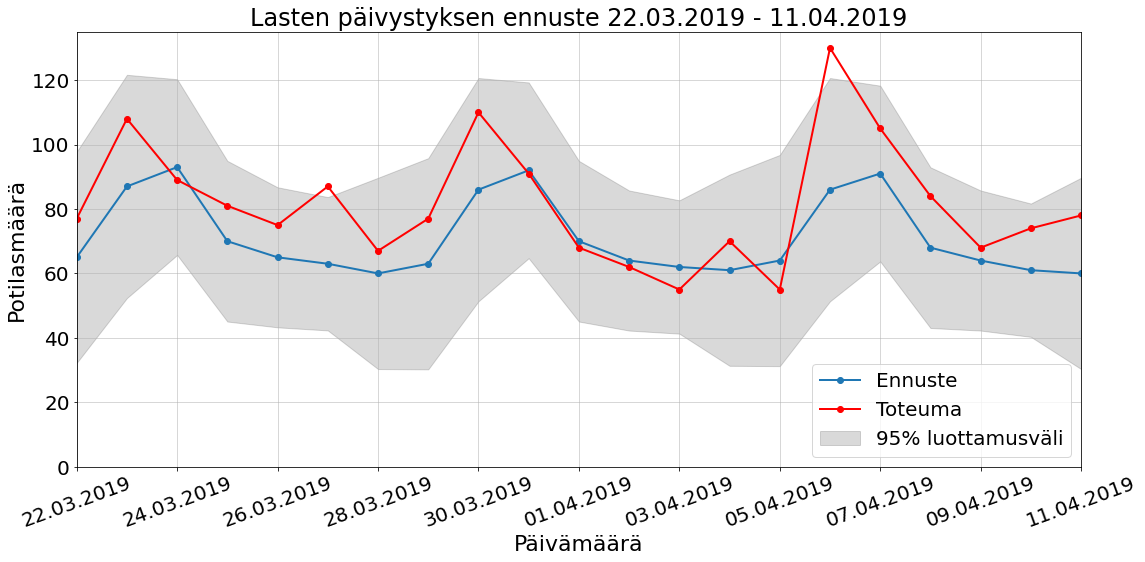

In [36]:
mean_series = final_results['0'][21:42]
start_weekday = start_day.weekday()
ninety_five = pd.concat([train_ninety_five.loc[start_weekday:], train_ninety_five, train_ninety_five, train_ninety_five, train_ninety_five, train_ninety_five, train_ninety_five]).reset_index(drop=True)[21:42].squeeze()
lower_series = final_results['0'][21:42] - ninety_five
upper_series = final_results['0'][21:42] + ninety_five
ER_true = df_test_day.patient_count.reset_index(drop=True)[21:42]
time_range = df_test_day.index[21:42]

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(18, 8))
plt.plot(mean_series, marker='o', linewidth=2)
plt.plot(ER_true, color='red', marker='o', linewidth=2)
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15)
plt.ylim([0, 135])
plt.xticks(ticks=ER_true.index, labels=pd.date_range(start=time_range[0], end=time_range[-1]).strftime('%d.%m.%Y'), rotation=20)
plt.locator_params(axis='x', nbins=11)
plt.title("Lasten päivystyksen ennuste 22.03.2019 - 11.04.2019", fontsize=24)
plt.legend(["Ennuste", "Toteuma", "95% luottamusväli"], loc ="lower right")
plt.xlabel('Päivämäärä', fontsize=22)
plt.ylabel('Potilasmäärä', fontsize=22)
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

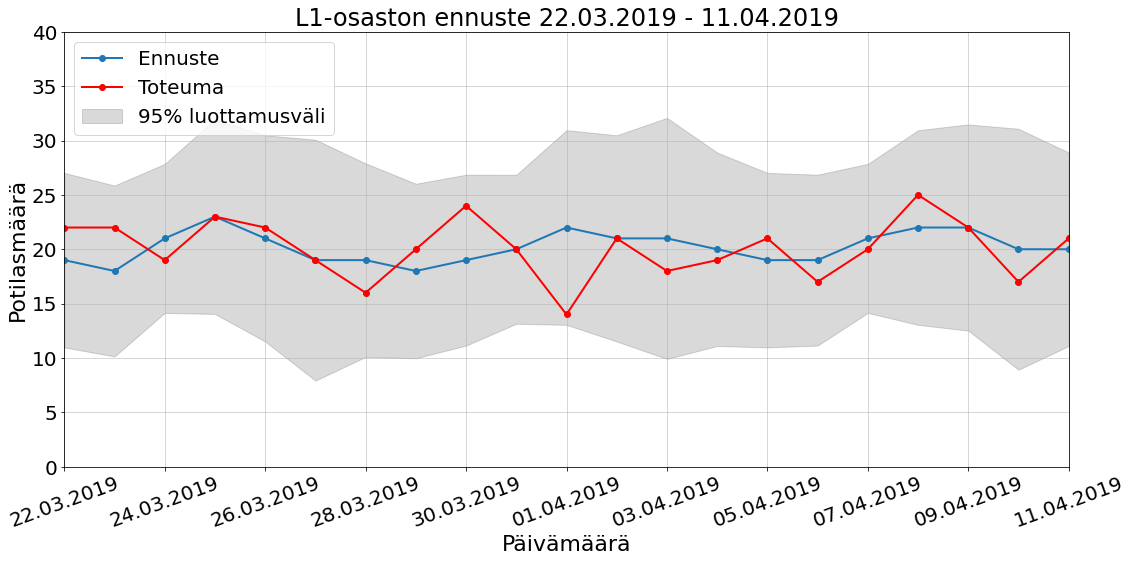

In [34]:
mean_series = final_results['1'][21:42]
start_weekday = start_day.weekday()
ninety_five = pd.concat([ward_ninety_five.loc[start_weekday:], ward_ninety_five, ward_ninety_five, ward_ninety_five, ward_ninety_five, ward_ninety_five, ward_ninety_five]).reset_index(drop=True)[21:42].squeeze()
lower_series = final_results['1'][21:42] - ninety_five
upper_series = final_results['1'][21:42] + ninety_five
new_index = np.arange(21, 42)
L1_true = ward_test_day.patient_count.reset_index(drop=True)[21:42]
time_range = df_test_day.index[21:42]

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(18, 8))
plt.plot(mean_series, marker='o', linewidth=2)
plt.plot(L1_true, color='red', marker='o', linewidth=2)
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15)
plt.ylim([0, 40])
plt.xticks(ticks=L1_true.index, labels=pd.date_range(start=time_range[0], end=time_range[-1]).strftime('%d.%m.%Y'), rotation=20)
plt.locator_params(axis='x', nbins=11)
plt.title("L1-osaston ennuste 22.03.2019 - 11.04.2019", fontsize=24)
plt.legend(["Ennuste", "Toteuma", "95% luottamusväli"], loc ="upper left")
plt.xlabel('Päivämäärä', fontsize=22)
plt.ylabel('Potilasmäärä', fontsize=22)
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()